# Solution of Linear PDEs in High Dimensions


In this Jupyter Notebook we illustrate a PDE solver based on the Feynman-Kac formula as proposed in

- Beck, Christian, et al. *Solving stochastic differential equations and Kolmogorov equations by means of deep learning*. [arXiv 1806.00421](https://arxiv.org/abs/1806.00421).

This notebook is partially based on the TensorFlow 1 code appended to the aforementioned preprint.

<a href="https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/Feynman_Kac_Solver.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Introduction

We consider the solution by neural network methods of a class of partial differential equations which arise as the *backward Kolmogorov equation* of stochastic processes known as *Itô diffusions*.
We begin with linear parabolic second-order partial differential equation in non-divergence form

$$
\begin{aligned}
    \partial_t u(t,x) + \frac{1}{2} \sigma \sigma^T(t,x) : \nabla^2 u(t,x) + \mu(t,x) \cdot \nabla u(t,x) 
    &= 0, 			\quad && (t,x) \in [0,T) \times \mathbb R^d,\\
    u(T,x) &= g(x), 	\quad && x \in \mathbb R^d,
\end{aligned}
$$

and subsequently move to more general PDEs.
We consider the pure Cauchy problem, allowing the state variable $x$ to vary throughout $\mathbb R^d$, were $d \in \mathbb{N}$ is the spatial dimension, 
$\nabla u(t,x)$ and $\nabla^2 u(t,x)$ denote the gradient and Hessian of the function $u$, respectively, the colon $:$ denotes the Frobenius inner product of $d \times d$ matrices, i.e., $A:B = \sum_{i,j=1}^d a_{ij} \, b_{ij}$, and the dot $\cdot$ the Euclidean inner product on $\mathbb R^d$.
We assume the coefficient functions $\mu\colon[0,T] \times \mathbb R^d \to \mathbb R^d$ (drift) and $\sigma\colon[0,T] \times\mathbb R^d \to \mathbb R^{d \times d}$ (diffusion) to be globally Lipschitz continuous.
Due to the stochastic process connection, the backward Kolmogorov equation is posed as a *final time problem* with data prescribed at time $t=T$ given by a function $g\colon \mathbb R^d \to \mathbb R$.
The simple change of variables $t \mapsto T - t$ leads to the more familiar initial value form

$$
\begin{aligned}
   \partial_t u(t,x) - \frac{1}{2} \sigma \sigma^T(t,x) : \nabla^2 u(t,x) - \mu(t,x) \cdot \nabla u(t,x) 
   &= 0, 			\quad && (t,x) \in (0,T] \times \mathbb R^d,\\
   u(0,x) &= g(x), 	\quad && x \in\mathbb R^d.
\end{aligned}
$$

Equations in non-divergence form like the backward Kolmogorov equation with  leading term $\sigma \sigma^T(t,x) \colon \nabla^2u(t,x)$ typically arise in the context of stochastic differential equations (SDEs) due to the Itô formula.

The goal of the computations that follow is to approximate the solution of the PDE at a fixed time $t=0$, i.e., the function $u(0,x)$ where $x$ varies over some $d$-dimensional hypercube $\mathcal{D} := [a,b] \subset \mathbb{R}^d$ with endpoint vectors $a \le b$ (component-wise). We denote this approximation by $u_\theta(x)$, where $\theta$ denotes a vector of parameters describing the degrees of freedom of the approximation.

## Theoretical Background
The method is based on the Feynman-Kac formula for Kolmogorov PDEs which connects such PDEs with the expectation of a stochastic process.

Given a filtered probability space $(\Omega, \mathcal{F}, \mathbb{P}; \mathbb{F})$ equipped with the filtration $\mathbb{F}=\{\mathcal{F}_t\}_{t\in[0,T]}$ induced by a Brownian motion $\{W_t\}_{t \in [0,T]}$,
the stochastic process $\{X_t\}_{t \in [0,T]}$ governed by the SDE 

$$
X_t = x + \int_0^t \mu(s, X_s) \, ds + \int_0^t \sigma(s, X_s) \, dW_s,
\qquad t \in [0,T]
$$

describes the evolution of the state variable in $\mathbb R^d$. The Feynman-Kac formula connects the solution of the (linear) PDE given above with this stochastic process.
Specifically, its solution at a point $(t,x) \in [0,T] \times \mathbb R^d$ is given by the conditional expectation

$$
u(t,x) = \mathbb{E} [g(X_T) | X_t = x].
$$

This connection can be exploited to approximate the PDE solution at a fixed point in space and time $(t,x)$ by simulating many paths/realizations of the stochastic process
$\{X^j_\tau\}_{\tau \in [t,T]}$, which all start at $X_t=x$
for $j=1,\ldots,n_{samples}$ and approximating the expectation by the sample average

$$
u(t,x) \approx \frac{1}{n_{samples}} \sum_{j=1}^{n_{samples}} g(X_T^j).
$$

The method reviewed here differs in that it constructs, for a fixed time $t_0$ (we set $t_0=0$ below), an approximation of the solution not only at a single point $(t_0,x) \in [0,T] \times \mathbb{R}^d$ but throughout a bounded domain of interest $\mathcal{D} \subset \mathbb{R}^d$.

## Solution Method
The approach relies on

1. the generation of training data by generating sample paths of the stochastic process $\{X_t\}_{t \in [0,T]}$ and
2. a neural network approximation of the unknown function $u(0,x) \approx u_\theta(x)$.

### Step 1: Generation of training data

The neural network model is trained with data pairs $(x, y)$ such that the values of $x$ are realizations of a random variable $X \sim \mathsf U (\mathcal D)$ and $y = g(X_T)$, where $X_T$ is the final value at $t=T$ of the stochastic process $\{X_t\}_{t \in[0,T]}$ evolving according to the SDE

$$
X_T = x + \int_0^T \mu(s, X_s) \, ds + \int_0^T \sigma(s, X_s) \, dW_s.
$$

Each path of the process starts at a uniformly drawn initial point $X_0 = x$.
We distinguish two cases:

#### Simple case: Distribution of $X_T$ explicitly known

When the probability distribution of $X_T$ is explicitly known, we can draw pairs $(x,y)$ directly.
For example, when $\{X_t\}$ is a scaled Brownian motion with dynamics characterized by $\mu(t,x) \equiv 0$ and $\sigma(t,x) \equiv \sigma$, the solution process is given by

$$
X_t = x + \sigma \, W_t, \qquad 0 \le t \le T.
$$

Thus, we may draw $x$ from $\mathsf U (\mathcal D)$ and set $y := g(x + \sqrt{T} \, \sigma \, \xi)$ where $\xi \sim \mathsf N (0, \mathrm{Id}_{d \times d})$ is a random variable with a $d$-variate standard normal distribution.

#### General case: Distribution of $X_T$ unknown

When the solution process is not available in closed form, we can still generate approximate sample paths of $\{X_t\}_{t \in [0,T]}$ numerically in order to sample from $X_T$.
This can be done, for example, using the Euler-Maruyama scheme:

$$
\tilde X_{n+1} := \tilde X_{n}
    + \mu(t_n, \tilde X_{n}) \, (t_{n+1} - t_n)
    + \sigma(t_n, \tilde X_{n}) \, (W_{t_{n+1}} - W_{t_n}),
\qquad
\tilde X_0 := x,
$$

where $\tilde X_n \approx  X_{t_n}$ and $0=t_0 < t_1 < \ldots < t_N = T$ is a discretization of the time domain.
Note that the increment of a Brownian motion $(W_{t_{n+1}} - W_{t_n}) \sim \mathsf{N}(0,(t_{n+1} - t_n) I_{d\times d})$ is normally distributed.
Finally, we set $y := g(\tilde X_N)$.

*Note*: Strong convergence results for the Euler-Maruyama scheme (cf. [Kloeden, Platen (1992)](https://www.springer.com/de/book/9783540540625)) ensure that $\tilde X_n \to X_{t_n}$ pathwise as $N \to \infty$ and $\sup |t_n - t_{n-1}| \to 0$.

### Step 2: Neural network approximation
The PDE solution $u \colon [0,T] \times \mathcal D \to \mathbb R$ is now approximated by neural networks with structure as given in [Beck et al. (2018)](https://arxiv.org/abs/1806.00421) as

    Input -> BN -> (Dense -> BN -> TanH) -> (Dense -> BN -> TanH) -> Dense -> BN -> Output
    
Here, `BN` denotes Batch Normalization, `Dense` a fully connected layer **without** bias term and activation and `TanH` the application of the componentwise hyperbolic tangent activation function

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}.
$$

## Example: Heat equation

As an example, consider the Cauchy problem for the $d$-dimensional heat equation

$$
\partial_t u(t,x) = \Delta u (t,x), \qquad
u(0,x) = \|x\|^2,
$$
where $\Delta u = \sum_{i=1}^d \partial^2 u/\partial x_i^2$ denotes the Laplacian of $u$.

The problem is posed as an initial value problem with drift coefficient $\mu(t,x) \equiv 0$ and diffusion coefficient $\sigma(t,x) \equiv \sqrt 2 $. One easily verifies that the solution is given by

$$
u(t,x) = \|x\|^2 + 2 \, t \, d.
$$

Our domain of interest is chosen as the $d$-dimensional unit cube $\mathcal D = [0,1]^d$.

In the following, we pesent code fragments for solving the heat equation in 100 spatial dimensions. 
The running time is reduced significantly by GPU acceleration, such as is available when running this Jupyter notebook on Google Colab (roughly 1 hour). Remember to explicitly enable GPU mode in the settings.

<a href="https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/Feynman_Kac_Solver.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 1. Initialize problem
This code runs with current TensorFlow versions (tested with 2.3.0 and 2.4.1).
First, we import some necessary packages.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))

TensorFlow version used: 2.8.2


Next, we set some problem specific data.

In [2]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimension
dim = 100

# Spatial domain of interest at t=0 (hyperrectangle)
a = np.zeros((dim), dtype=DTYPE)
b = np.ones((dim), dtype=DTYPE)

# Diffusion coefficient is assumed to be constant
sigma = np.sqrt(2, dtype=DTYPE)

# Define initial time condition
def fun_g(x):
    return tf.reduce_sum(tf.pow(x,2), axis=1, keepdims=True)

# Define exact reference solution 
def fun_u(t, x):
    return tf.reduce_sum(tf.pow(x,2), axis=1, keepdims=True) + 2 * t * dim

### 2. Generation of training data
Next, we define a method to generate `num_samples` of training data $(x, y)$.
We are in the setting where we know the distribution of $X_T$. 
Thus, it suffices to
- draw $x$ uniformly from $\mathcal D$, i.e.,
$$X \sim \mathsf U(\mathcal D),$$
- set
$$y := g(X + \sigma \, \sqrt{T} \,\xi),$$\
where $\xi \sim \mathsf N(0, \mathrm{Id}_{d \times d})$ is drawn from a $d$-variate standard normal distribution.

In [3]:
@tf.function
def draw_X(num_samples, a, b, sigma=1.0):
    """ Function to draw num_samples pairs of starting values X_0 
    and end points X_T of a stochastic process X with zero drift and
    constant scalar diffusion. Starting points are drawn uniformly from the
    hypercube [a,b] \\subset \mathbb{R}^d. """
    dim = a.shape[0]
    
    X0 = a + tf.random.uniform((num_samples, dim), dtype=DTYPE) * (b-a)

    # Initialize the array X
    xi = tf.random.normal(shape=(num_samples, dim), dtype=DTYPE)
    
    XT = X0 + sigma * np.sqrt(T) * xi

    # Return simulated paths as well as increments of Brownian motion
    return tf.stack([X0, XT], 2)

### 3. Set up neural network model

The next function returns a neural network model in which one may change the used activation function (default: $\tanh$) as well as the number of hidden neurons (default: $n_{hidden}=100$) in each of the hidden layers.

    Input -> BN -> (Dense -> BN -> TanH) -> (Dense -> BN -> TanH) -> Dense -> BN -> Output
    
Here, `BN` denotes Batch Normalization, `Dense` indicates a fully connected layer **without** bias term and activation, `TanH` refers to the componentwise application of the hyperbolic tangent activation function.

The chosen model contains a total of $11\,944$ unknown parameters allotted to the network components as 

$$
\begin{aligned}
\underbrace{4\cdot d}_{\texttt{BN0}}
+ \underbrace{d\cdot n}_{\texttt{Dense1}}
+ \underbrace{4\cdot n}_{\texttt{BN1}}
+ \underbrace{n\cdot n}_{\texttt{Dense2}}
+ \underbrace{4\cdot n}_{\texttt{BN2}} &
+ \underbrace{n\cdot 1}_{\texttt{Dense3}}
+ \underbrace{4\cdot 1}_{\texttt{BN3}}
\\
&\quad= 4\,(d + 1) + n\,(d+9) + n^2
\end{aligned}
$$

In [4]:
def init_model(dim, activation='tanh',
               num_hidden_neurons=100,
               num_hidden_layers=2,
               initializer=tf.keras.initializers.GlorotUniform()):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(dim))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_hidden_neurons,
                                activation=None,
                                use_bias=False,
                                kernel_initializer=initializer
                                ))
        model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
        model.add(tf.keras.layers.Activation(activation))
    
    model.add(tf.keras.layers.Dense(1,
                                    activation=None,
                                    use_bias=False,
                                    kernel_initializer=initializer
                                    ))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))

    return model

### 4. Define functions for the objective and its gradient
In the next step, we define the loss function, i.e., the function to be minimized in the neural network's training.
To achieve $u_\theta(T,x) \approx u(T,x) = \mathbb{E}[g(X_T) | X_0=x]$, we minimize the mean-square error (MSE)

$$
\mathbb{E} [ |g(X_T) - u_\theta(T,x)|^2 ],
$$

where the expectation is taken with respect to the joint distribution of initial values and sample paths.
The existence of a unique function $u$ which minimizes this objective and solves the PDE is based on Prop. 2.7 of [Beck et al. (2018)](https://arxiv.org/abs/1806.00421).

For batches of size $m$, we approximate this quantity by the sample mean

$$
\frac{1}{m} \sum_{i=1}^m |y^i - u_\theta(T,x^i)|^2,
$$

where $x^i$ is drawn uniformly from ${\mathsf U}(\mathcal D)$ and $y^i$ is a realization of $g(X_T^i)$ where $X_0^i = x^i$.

In [5]:
def loss_fn(X, y, model, training=False):
    """ This function computes the mean squared error between the current model
    prediction model(X) and the values y.
    Inputs:
        X - approximation to the state process X
        y - target value
        model - model of neural network approximating x -> u(T,x)
        training - boolean flag to indicate training
    """

    X0 = X[:,:,0]
    y_pred = model(X0, training)
    
    # Return mean squared error
    return tf.reduce_mean(tf.math.squared_difference(y, y_pred))

The next step uses the automatic differentiation functionality of TensorFlow to compute the gradient of the loss function with respect to the unknowns $\theta$, called `trainable_variables` in TensorFlow.

In [6]:
@tf.function
def compute_grad(X, y, model, training=False):
    """ This function computes the gradient of the loss function w.r.t.
    the trainable variables theta.
    Inputs:
        X - approximation to the state process X
        y - target value
        model - model of neural network approximating x -> u(T,x)
        training - boolean flag to indicate training
    """
    with tf.GradientTape() as tape:
        loss = loss_fn(X, y, model, training)
    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

### 5. Solve the PDE

Next, we initialize the model and choose an optimizer as well as a learning rate schedule.

The optimizer which performs the gradient descent step and in particular its step size (aka learning rate) have to be chosen carefully.
The speed of convergence can depend strongly on the initialization of the unknown network parameters $\theta$ as well as the optimizer settings, e.g., choosing the learning rate too high may yield a divergent sequence while values which are too low may result in slow convergence.

In addition, we define a test data set $(X_{test}, Y_{test})$ consisting of uniformly drawn points $x^i_{test} \subset \mathcal D$ and target values $y^i_{test} = u(T,x^i_{test}).$

In [7]:
# Original experiment
model = init_model(dim=dim, num_hidden_neurons=200)
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([250001,500001],[1e-3,1e-4,1e-5])
suffix='orig'

# Exponential decay
#model = init_model(dim=dim, num_hidden_neurons=200)
#lr = tf.keras.optimizers.schedules.ExponentialDecay(1e-1,100000,.1)
#suffix='exp'

# More layers and neurons experiment
#model = init_model(dim=dim, num_hidden_neurons=300, num_hidden_layers=3)
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([250001,500001],[1e-3,1e-4,1e-5])
#suffix='more'

# Even more
#model = init_model(dim=dim, num_hidden_neurons=400, num_hidden_layers=4)
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([250001,500001],[1e-3,1e-4,1e-5])
#suffix='even_more'

# Deep ReLU Networks
#model = init_model(dim=dim, num_hidden_neurons=200, num_hidden_layers=4, initializer=tf.keras.initializers.HeNormal())
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([250001,500001],[1e-3,1e-4,1e-5])
#suffix='relu'

# Set number of training epochs
num_epochs = 750001

# Set batch size
batch_size = 8192

# Choose an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

# Initialize list containing history of losses
hist_loss = []
error_hist = []

# Randomly choose a test set from \mathcal{D} to approximate
# errors by means of Monte Carlo sampling
n_test = 1000000
X = draw_X(n_test, a, b, sigma=sigma)
Xtest = X[:,:,0]
# Compute exact solution
Ytest = fun_u(T,Xtest)

Next, we train the model.
Here, we decided to make this explicit in order to show what happens in detail.
Note, however, that one might implement a `Python generator` or `tf.keras.utils.Sequential` object to provide the training data and use the `fit()` method from the `tf.keras.Model` object to train the model.

**Note**: The following code cell has a runtime of about 60 minutes on Google Colab with GPU acceleration.

In [8]:
# Define a training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Draw batch of random paths
    X = draw_X(batch_size, a, b, sigma=sigma)
    
    # Evaluate g at X_T
    y = fun_g(X[:,:,-1])

    # And compute the loss as well as the gradient
    loss, grad = compute_grad(X, y, model, training=True)

    # Perform gradient step
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# Start timer
t0 = time()


# Set interval to estimate errors
log_interval = 1000


# Initialize header of output
print('  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time  Stepsize')

# Loop to train model
for i in range(num_epochs):

    # Perform training step
    loss = train_step()
    hist_loss.append(loss)

    if i % log_interval == 0:
        
        # Compute current prediction on test set
        Ypred = model(Xtest, training=False)
        
        # Compute absolute and relative errors
        abs_error = np.abs(Ypred - Ytest)
        rel_error = abs_error/Ytest
        L2_rel = tf.sqrt(tf.reduce_mean(tf.pow(rel_error, 2))).numpy()
        L1_rel = tf.reduce_mean(tf.abs(rel_error)).numpy()
        Linf_rel = tf.reduce_max(tf.abs(rel_error)).numpy()
        
        L2_abs = tf.sqrt(tf.reduce_mean(tf.pow(abs_error, 2))).numpy()
        L1_abs = tf.reduce_mean(tf.abs(abs_error)).numpy()
        Linf_abs = tf.reduce_max(tf.abs(abs_error)).numpy()
        total_time = time()-t0
        stepsize = optimizer.lr(optimizer.iterations).numpy()
        err = (i, loss.numpy(), L1_rel, L2_rel, Linf_rel, L1_abs, L2_abs, Linf_abs, total_time, stepsize)
        error_hist.append(err)
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}   {:8.4f} | {:8.4f} {:8.4f}   {:8.4f}  |  {:6.1f}  {:6.2e}'.format(*err))
print(time()-t0)

  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time  Stepsize
    0   55655.3086   0.9980   0.9980     1.0033 | 232.8636 232.8825   247.7460  |     6.8  1.00e-03
 1000   54995.2734   0.9959   0.9959     1.0165 | 232.3457 232.3495   242.4067  |    12.4  1.00e-03
 2000   54668.0156   0.9918   0.9919     1.0179 | 231.3910 231.3931   239.7604  |    17.0  1.00e-03
 3000   54374.3281   0.9874   0.9875     1.0171 | 230.3666 230.3683   237.7161  |    21.6  1.00e-03
 4000   53878.5625   0.9835   0.9836     1.0149 | 229.4449 229.4465   236.0798  |    26.2  1.00e-03
 5000   53369.9141   0.9792   0.9792     1.0105 | 228.4358 228.4373   234.7415  |    30.8  1.00e-03
 6000   52697.8125   0.9745   0.9746     1.0064 | 227.3557 227.3572   233.8336  |    35.4  1.00e-03
 7000   52347.0234   0.9701   0.9702     1.0033 | 226.3265 226.3280   232.6743  |    40.1  1.00e-03
 8000   52069.5469   0.9656   0.9656     0.9991 | 225.2649 225.2663   231.4037  |    44.8  1.00e-03


### Plot of the training history

Text(0, 0.5, 'training loss')

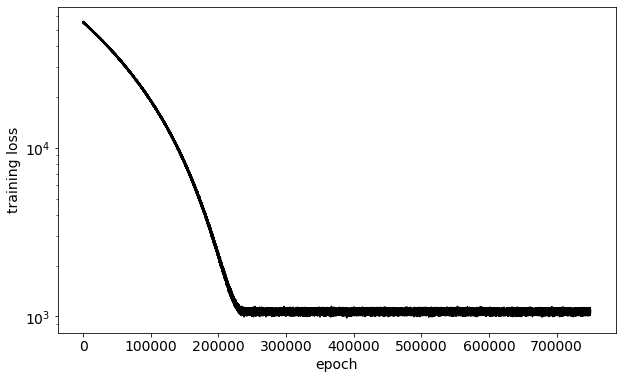

In [9]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.semilogy(range(len(hist_loss)), hist_loss,'k-')
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')

### Plot of the absolute and relative errors

(<matplotlib.legend.Legend at 0x7f32b63b6550>,)

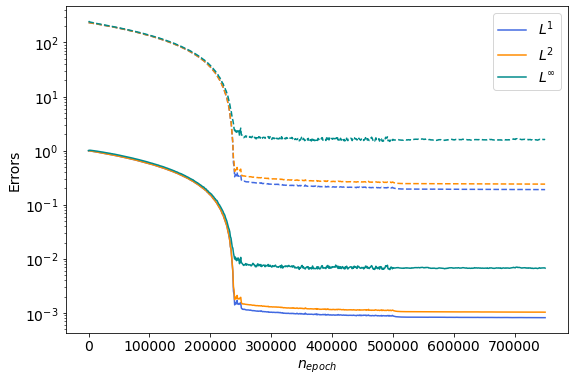

In [10]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.set_prop_cycle(color=['royalblue', 'darkorange', 'darkcyan'])
start_idx = 0
xrange = [e[0] for e in error_hist[start_idx:]]
ax.semilogy(xrange, [e[2:5] for e in error_hist[start_idx:]])
ax.semilogy(xrange, [e[5:8] for e in error_hist[start_idx:]], linestyle='--')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Errors')
ax.legend(['$L^1$', '$L^2$', '$L^{\infty}$']),
#plt.savefig('Errors_HeatEquation_dim_{:03d}_{:s}.pdf'.format(dim,suffix), bbox_inches='tight', dpi=300)

In [11]:
SAVE_CSV = False
if SAVE_CSV:
    import csv
    with open('heat_dim_{:03d}_{:s}.csv'.format(dim, suffix),'w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['Iter', 'Loss', 'L1_rel', 'L2_rel', 'Linf_rel', 'L1_abs', 'L2_abs', 'Linf_abs', 'Time', 'Stepsize'])
        for row in error_hist:
            csv_out.writerow(row)

### Plot slice of solution and rel. error

Text(0.5, 0, '$x_2$')

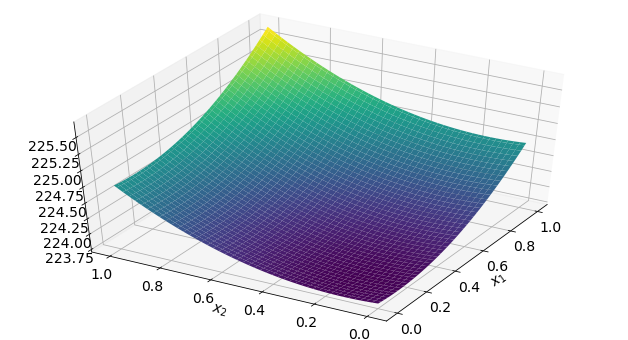

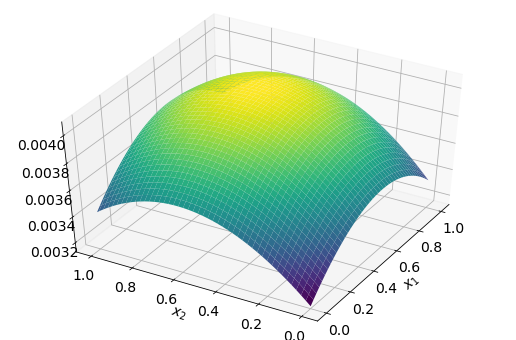

In [12]:
ngrid = 400

# Choose indices to plot
idx0 = 0
idx1 = 1

# Determine remaining indices
idx = np.arange(dim)
idx_remaining = np.setdiff1d(idx,[idx0,idx1])
# Set remaining values to midpoints
val_remaining = (a+b)/2

# Meshgrid for plots
xspace = np.linspace(a[idx0], b[idx0], ngrid + 1, dtype=DTYPE)
yspace = np.linspace(a[idx1], b[idx1], ngrid + 1, dtype=DTYPE)
X,Y = np.meshgrid(xspace, yspace)

# Append remaining values
Z = np.repeat(val_remaining[idx_remaining].reshape(1,-1), (ngrid+1)**2,axis=0)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
Xgrid = np.hstack([Xgrid,Z])

# Relative error
urel =tf.abs(model(Xgrid,training=False) -  fun_u(T,Xgrid))/fun_u(T,Xgrid)
Urel = urel.numpy().reshape(ngrid+1,ngrid+1)
# Slice of solution
U = model(Xgrid,training=False).numpy().reshape(ngrid+1,ngrid+1)

# Plot solution of heat equation
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,U,cmap='viridis')
ax.view_init(45,210)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
#plt.savefig('Sol_HeatEquation_dim_{:03d}_{:s}.pdf'.format(dim,suffix), bbox_inches='tight', dpi=300)

# Plot relative error of heat equation
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Urel,cmap='viridis')
ax.view_init(45,210)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
#plt.savefig('RelError_HeatEquation_dim_{:03d}_{:s}.pdf'.format(dim,suffix), bbox_inches='tight', dpi=300)

## Example: Option pricing
In this example, we study the Black-Scholes formula, one of the basic models used in mathematical finance to determine the fair value of derivatives.

We consider a financial market with 100 uncorrelated risky assets whose underlying dynamics is given by a geometric Brownian motion, i.e., a stochastic process $\{X_t\}_{t \in [0,T]}$ governed by the SDE 

$$
X_t = x + \int_0^t \mu(s,X_s) \, ds + \int_0^t \sigma(s,X_s) \, dW_s,
\qquad t \in [0,T]
$$

with $\mu(s,x) \equiv -0.05 \, x$ and $\sigma(s,x) \equiv \mathrm{diag}(0.105 \, x_1, 0.110 \, x_2, \ldots, 0.600 \, x_{100})$.

Here, we consider a derivative whose fair value at $(t,x)$ is determined by the PDE

$$
\begin{aligned}
   \partial_t u(t,x) - \frac{1}{2} \sum_{i=1}^d | \sigma_i x_i |^2 \, \partial^2_{x_i} u(t,x) - \sum_{i=1}^d \mu_i x_i \partial_{x_i} u(t,x)
       &= 0, 			\quad && (t,x) \in (0,T] \times \mathbb R_+^d,\\
   u(0,x) &= g(x), 	\quad && x \in\mathbb R_+^d.
\end{aligned}
$$

with
$g(x) := \exp (-r \, T) \max \{
[ \max_{i\in\{1, \ldots, 100\}} x_i ] - 100, 0
\}.
$



The model is taken from [Beck et al., Sec. 3.3](https://arxiv.org/abs/1806.00421)

In [13]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimensions
dim = 100

# Domain-of-interest at t=0
a = 90 * tf.ones((dim), dtype=DTYPE)
b = 110 * tf.ones((dim), dtype=DTYPE)

# Interest rate
r = tf.constant(1./20, dtype=DTYPE)

# Drift
mu = tf.constant(-1./20, dtype=DTYPE)

# Strike price
K = tf.constant(100., dtype=DTYPE)

# Diffusion/volatility
sigma = 1./10 + 1./200*tf.range(1, dim+1, dtype=DTYPE)

# Define terminal condition, i.e., payoff at maturity
def fun_g(x):
    return tf.exp(-r*T) * tf.maximum(tf.reduce_max(x, axis=1, keepdims=True) - K, 0.)

In [14]:
@tf.function
def draw_X(num_samples, a, b):
    """ Function to draw num_samples many pairs of uniformly drawn starting
    values X_0 and end points X_T of a stochastic process X with zero drift and
    constant scalar diffusion. Starting points are drawn uniformly from the
    hypercube [a,b] \\subset \mathbb{R}^d. """
    dim = a.shape[0]
    
    X0 = a + tf.random.uniform((num_samples, dim), dtype=DTYPE) * (b-a)
    
    # Initialize the array X
    xi = tf.random.normal(shape=(num_samples, dim), dtype=DTYPE)
    XT = X0 * tf.exp( (mu- tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * xi)

    # Return simulated paths as well as increments of Brownian motion
    return tf.stack([X0, XT], 2)

In [15]:
# Initialize model
model = init_model(dim=dim, num_hidden_neurons=dim+100)

# Set up step size
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([250001,500001],[1e-3,1e-4,1e-5])

# Set number of training epochs
num_epochs = 750001

# Set batch size
batch_size = 8192

# Choose an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

# Initialize list containing history of losses
hist_loss = []
error_hist = []

Draw a test set with 250 000 samples and estimate the target values by means of Monte-Carlo estimation with $32 \times 32 000$ samples.

In [16]:
# Randomly choose a test set from \mathcal{D} to approximate
# errors by means of Monte Carlo sampling
n_test = 250000
X = draw_X(n_test, a, b)
Xtest = X[:,:,0]
Xtest = tf.convert_to_tensor(Xtest, dtype=DTYPE)

# Prepare Ytest
Ytest = tf.zeros((Xtest.shape[0],1),dtype=DTYPE)

# Determine values at Xtest through Monte-Carlo sampling
# Set batch size and mc_samples, results in b_size*mc_samples many iterates
b_size = 32
mc_samples = 32000

@tf.function
def mc_step(y):
    # Draw standard normal random variables
    Xi = tf.random.normal(shape=(b_size, dim), dtype=DTYPE)
    # Determine update
    upd = tf.exp( (mu- tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * Xi)
    # Determine X_T
    XT = tf.reshape(Xtest, shape=[n_test, dim, 1])*tf.transpose(upd)
    return y + tf.reduce_sum(tf.reshape(fun_g(XT),[n_test, b_size]), axis=1,keepdims=True)/(b_size*mc_samples)

for i in range(mc_samples):
    if i%100==0:
        print(i,'/',mc_samples)
    Ytest=mc_step(Ytest)

0 / 32000
100 / 32000
200 / 32000
300 / 32000
400 / 32000
500 / 32000
600 / 32000
700 / 32000
800 / 32000
900 / 32000
1000 / 32000
1100 / 32000
1200 / 32000
1300 / 32000
1400 / 32000
1500 / 32000
1600 / 32000
1700 / 32000
1800 / 32000
1900 / 32000
2000 / 32000
2100 / 32000
2200 / 32000
2300 / 32000
2400 / 32000
2500 / 32000
2600 / 32000
2700 / 32000
2800 / 32000
2900 / 32000
3000 / 32000
3100 / 32000
3200 / 32000
3300 / 32000
3400 / 32000
3500 / 32000
3600 / 32000
3700 / 32000
3800 / 32000
3900 / 32000
4000 / 32000
4100 / 32000
4200 / 32000
4300 / 32000
4400 / 32000
4500 / 32000
4600 / 32000
4700 / 32000
4800 / 32000
4900 / 32000
5000 / 32000
5100 / 32000
5200 / 32000
5300 / 32000
5400 / 32000
5500 / 32000
5600 / 32000
5700 / 32000
5800 / 32000
5900 / 32000
6000 / 32000
6100 / 32000
6200 / 32000
6300 / 32000
6400 / 32000
6500 / 32000
6600 / 32000
6700 / 32000
6800 / 32000
6900 / 32000
7000 / 32000
7100 / 32000
7200 / 32000
7300 / 32000
7400 / 32000
7500 / 32000
7600 / 32000
7700 / 3200

In [17]:
# Define a training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Draw batch of random paths
    X = draw_X(batch_size, a, b)
    
    # Evaluate g at X_T
    y = fun_g(X[:,:,-1])

    # And compute the loss as well as the gradient
    loss, grad = compute_grad(X, y, model, training=True)
    #hist_loss.append(loss)

    # Perform gradient step
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# Start timer
t0 = time()


# Set interval to estimate errors
log_interval = 1000


# Initialize header of output
print('  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time')

# Loop to train model
for i in range(num_epochs):

    # Perform training step
    loss = train_step()
    hist_loss.append(loss)

    if i % log_interval == 0:
        
        # Compute current prediction on test set
        Ypred = model(Xtest, training=False)
        
        # Compute absolute and relative errors
        abs_error = np.abs(Ypred - Ytest)
        rel_error = abs_error/Ytest
        L2_rel = tf.sqrt(tf.reduce_mean(tf.pow(rel_error, 2))).numpy()
        L1_rel = tf.reduce_mean(tf.abs(rel_error)).numpy()
        Linf_rel = tf.reduce_max(tf.abs(rel_error)).numpy()
        
        L2_abs = tf.sqrt(tf.reduce_mean(tf.pow(abs_error, 2))).numpy()
        L1_abs = tf.reduce_mean(tf.abs(abs_error)).numpy()
        Linf_abs = tf.reduce_max(tf.abs(abs_error)).numpy()
        
        total_time = time()-t0
        stepsize = optimizer.lr(optimizer.iterations)
        err = (i, loss.numpy(), L1_rel, L2_rel, Linf_rel, L1_abs, L2_abs, Linf_abs, total_time, stepsize)
        error_hist.append(err)
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}   {:8.4f} | {:8.4f} {:8.4f}   {:8.4f}  |  {:6.1f}  {:6.2e}'.format(*err))
#Y = model.call((X,dw))
print(time()-t0)

  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time
    0   29728.7891   0.9928   0.9928     0.9997 | 156.3706 156.3864   166.8998  |     3.2  1.00e-03
 1000   28828.3047   0.9938   0.9939     1.0184 | 156.5149 156.5167   163.4116  |     8.0  1.00e-03
 2000   28681.8828   0.9875   0.9875     1.0138 | 155.5077 155.5092   162.0543  |    12.8  1.00e-03
 3000   28644.5527   0.9812   0.9812     1.0092 | 154.5145 154.5155   160.9210  |    17.6  1.00e-03
 4000   27950.4199   0.9747   0.9747     1.0036 | 153.4893 153.4904   159.7545  |    22.4  1.00e-03
 5000   27697.5430   0.9685   0.9686     0.9989 | 152.5227 152.5237   158.6322  |    27.2  1.00e-03
 6000   27277.5918   0.9624   0.9625     0.9927 | 151.5579 151.5588   157.4296  |    32.0  1.00e-03
 7000   26979.4121   0.9563   0.9564     0.9863 | 150.5925 150.5933   156.2746  |    36.8  1.00e-03
 8000   26887.6621   0.9498   0.9499     0.9802 | 149.5757 149.5765   155.1525  |    41.6  1.00e-03
 9000   26

### Plot of the training history

Text(0, 0.5, 'training loss')

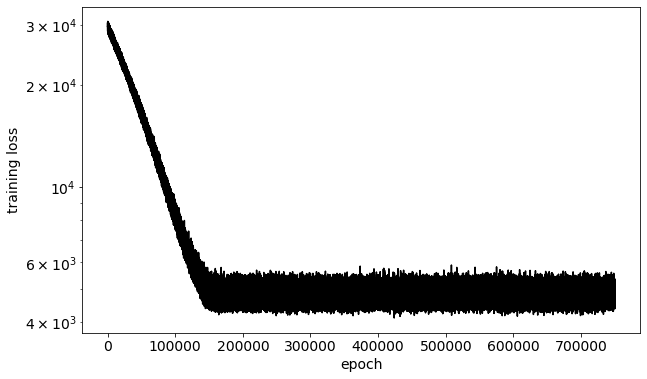

In [18]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.semilogy(range(len(hist_loss)), hist_loss,'k-')
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')

### Plot of the absolute and relative errors

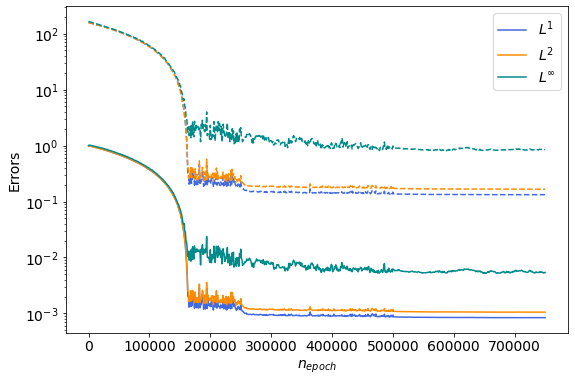

In [19]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.set_prop_cycle(color=['royalblue', 'darkorange', 'darkcyan'])
xrange = np.arange(len(error_hist))*log_interval
ax.semilogy(xrange, [e[2:5] for e in error_hist])
ax.semilogy(xrange, [e[5:8] for e in error_hist], linestyle='--')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Errors')
ax.legend(['$L^1$', '$L^2$', '$L^{\infty}$']),
plt.savefig('Errors_OptionPricing.pdf', bbox_inches='tight', dpi=300)

### Plot slice of solution and rel. error

In [20]:
ngrid = 100

# Choose indices to plot
idx0 = 0
idx1 = 1

# Determine remaining indices
idx = np.arange(dim)
idx_remaining = np.setdiff1d(idx,[idx0,idx1])
# Set remaining values to midpoints
val_remaining = np.array((a+b)/2)

# Meshgrid for plots
xspace = np.linspace(a[idx0], b[idx0], ngrid + 1, dtype=DTYPE)
yspace = np.linspace(a[idx1], b[idx1], ngrid + 1, dtype=DTYPE)
X,Y = np.meshgrid(xspace, yspace)

# Append remaining values
Z = np.repeat(val_remaining[idx_remaining].reshape(1,-1), (ngrid+1)**2,axis=0)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
Xgrid = np.hstack([Xgrid,Z])

n_test, dim = Xgrid.shape
uest = tf.zeros((n_test,1),dtype=DTYPE)

b_size = 512
mc_samples=2000

Xgrid = tf.convert_to_tensor(Xgrid, dtype=DTYPE)
@tf.function
def mc_step(y):
    Xi = tf.random.normal(shape=(b_size, dim), dtype=DTYPE)
    upd = tf.exp( (mu- tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * Xi)
    XT = tf.reshape(Xgrid, shape=[(ngrid+1)**2,dim,1])*tf.transpose(upd)
    tmp = tf.reduce_sum(tf.reshape(fun_g(XT),[(ngrid+1)**2,b_size]), axis=1,keepdims=True)/(b_size*mc_samples)
    return y + tmp

#mc_step(uest)
for i in range(mc_samples):
    if i%100==0:
        print(i,'/',mc_samples)

    uest=mc_step(uest)

0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000


Text(0.5, 0, '$x_2$')

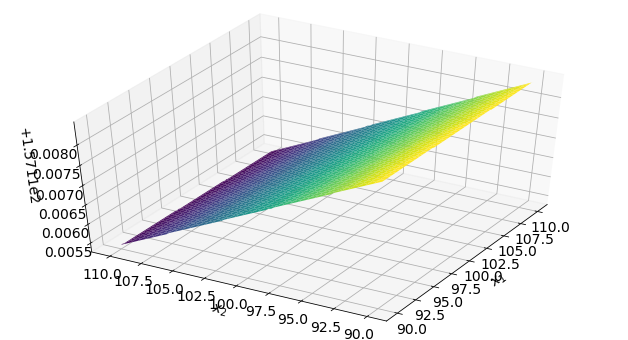

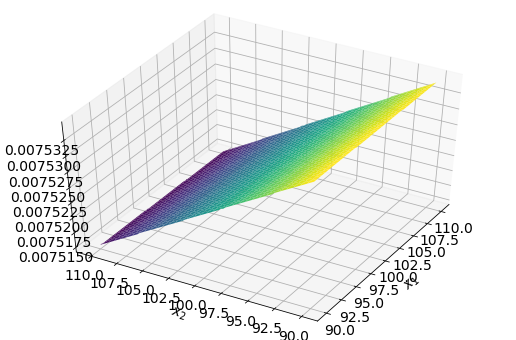

In [21]:
# Relative error
urel =tf.abs(model(Xgrid,training=False) -  uest)/uest

Urel = urel.numpy().reshape(ngrid+1,ngrid+1)
# Slice of solution
U = model(Xgrid,training=False).numpy().reshape(ngrid+1,ngrid+1)

# Plot solution of heat equation
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,U,cmap='viridis')
ax.view_init(45,210)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
#plt.savefig('Sol_OptionPricing.pdf', bbox_inches='tight', dpi=300)

# Plot relative error of heat equation
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Urel,cmap='viridis')
ax.view_init(45,210)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
#plt.savefig('RelError_OptionPricing.pdf', bbox_inches='tight', dpi=300)